# MNIST Digit Recognition with K-Means and KNN

This notebook implements a hybrid approach to handwritten digit recognition using K-means clustering for dimensionality reduction and K-Nearest Neighbors (KNN) for classification. Let's break down each step of the process and understand the reasoning behind our implementation choices.

## Data Processing and Initial Setup

We begin by importing necessary libraries and loading the MNIST dataset. The MNIST dataset is a large collection of handwritten digits that serves as a standard benchmark for machine learning algorithms.

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import time
import seaborn as sn
from sklearn.metrics import confusion_matrix


### Data Splitting strategy

We Split our data into training and testing sets with specific considerations:
1. Take the last 10,000 samples for testing
2. Use the remaining samples for training
3. Reset indices to ensure clean data handling

In [3]:
# Load MNIST dataset
mnist = fetch_openml('mnist_784')

# Split the data into features (X) and labels (y)
X = mnist.data
y = mnist.target

print(X.shape, y.shape)

(70000, 784) (70000,)


In [10]:
# Split the data into training and testing sets
X_test = X[-10000:].reset_index(drop=True)  # Reset the indices to avoid errors
y_test = y[-10000:].reset_index(drop=True)
X_train = X[:-10000]
y_train = y[:-10000]

print(X_train.shape, y_train.shape)

(60000, 784) (60000,)


### Dimensionality Reduction 

Our strategy for reducing the computational complexity involves:
1. Grouping training data by digit (0-9)
2. Applying K-means clustering (k=9) to each digit group
3. Using cluster centers as representative samples

This Approach:
- Reduces our training set to just 90 samples
- Preserves the essential characteristics of each digit
- Significantly improves the runtime of KNN classification

In [11]:
# Convert the data and target to a DataFrame
df = pd.DataFrame(X_train)
df['target'] = y_train

# Create a dictionary of DataFrames, each corresponding to a unique digit
groups = {digit: data for digit, data in df.groupby('target', observed=False)}

# Initialize an empty DataFrame for the final training set
rows, cols = df.drop('target', axis=1).shape
final_train_set = pd.DataFrame()
kmeans = KMeans(n_clusters=9)

# For each group, sample 9 digits and append to the final training set
for digit, data in groups.items():
    
    kmeans.fit(data.drop('target', axis=1))
    means = pd.DataFrame(kmeans.cluster_centers_)
    means['target'] = digit
    final_train_set = pd.concat([final_train_set, means], ignore_index=True)

# Split the final training set into features (X) and labels (y)
X_train_approx = final_train_set.drop('target', axis=1)
y_train_approx = final_train_set['target']

print(X_train_approx.shape, y_train_approx.shape)


(90, 784) (90,)


## Data Distribution Analysis

Before proceeding with classification, it's crucial to verify that our data splitting hasn't introduced any bias. We visualize the distribution of digits in both training and test sets to ensure they're similarly distributed.

Key aspects we're checking:
1. Relative frequency of each digit
2. Balance between classes
3. Any potential sampling bias

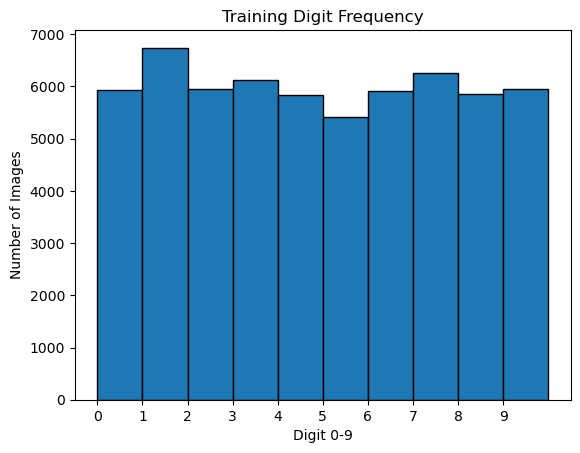

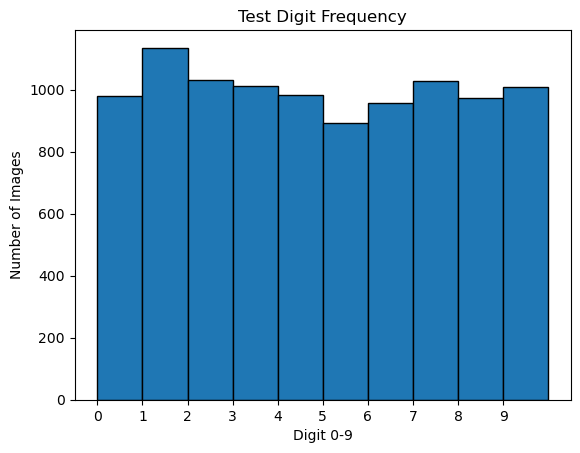

In [5]:

# Convert the target and prediction columns to integers to avoid errors
y_train = y_train.astype(int) 
y_test = y_test.astype(int)

# Create a histogram of the digit frequency in the training dataset
plt.hist(y_train, bins=10, range=(0,10), edgecolor='black')
plt.title('Training Digit Frequency')
plt.xlabel('Digit 0-9')
plt.ylabel('Number of Images')
plt.xticks(range(10))
plt.show()

# Create a histogram of the digit frequency in the test dataset
plt.hist(y_test, bins=10, range=(0,10), edgecolor='black')
plt.title('Test Digit Frequency')
plt.xlabel('Digit 0-9')
plt.ylabel('Number of Images')
plt.xticks(range(10))
plt.show()


# Classification Implementation

We use K-Nearest Neighbors (KNN) with k=1 for classification because:
1. After K-means clustering, each center already represents multiple similar images
2. Using k=1 in KNN is sufficient since our training data consists of averaged representations
3. The reduced dataset size makes computational complexity less of a concern

We also measure prediction time to quantify the efficiency gains from our approach.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)

# Create a DataFrame with feature and target training values
classifier_dict = {feature: X_test[feature] for feature in mnist.feature_names}
classifier_dict['target'] = y_test
classifier_df = pd.DataFrame(classifier_dict)

knn.fit(X_train_approx, y_train_approx)   # Fit the classifier to the training data

# Calculate the prediction time in seconds and add to the DataFrame
start_time = time.time()
y_pred = knn.predict(X_test)    # Predict the test data
end_time = time.time()
prediction_time = (end_time - start_time).__round__(2)  
classifier_df['prediction'] = y_pred    

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


## Results Analysis
 
We analyze our results through three key visualizations:
1. K-means cluster visualization - to understand what patterns the clustering found
2. Confusion matrix - to identify where our model succeeds and fails
3. Sample predictions - to qualitatively assess model performance

For each digit (0-9), we display the 9 cluster centers our K-means algorithm identified. <br>
This helps us understand:
- What variations of each digit the model captured
- Whether the clusters are meaningful and distinct
- If any important digit variations were missed

/var/folders/n4/_628flvn3t96dj4flkfjwt6r0000gq/T/ipykernel_271/4087594192.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[i,j].set_title('digit ' + str(row_identifiers[-2]) + ' cluster ' + str(row_identifiers[-1]))


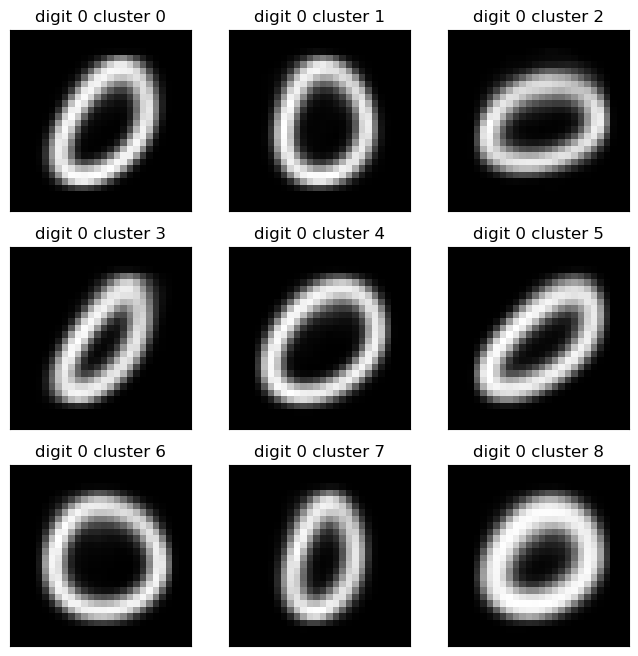

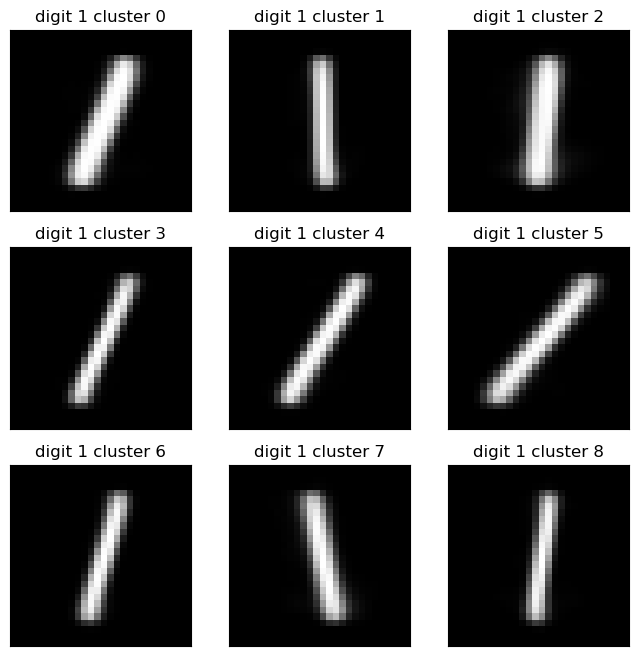

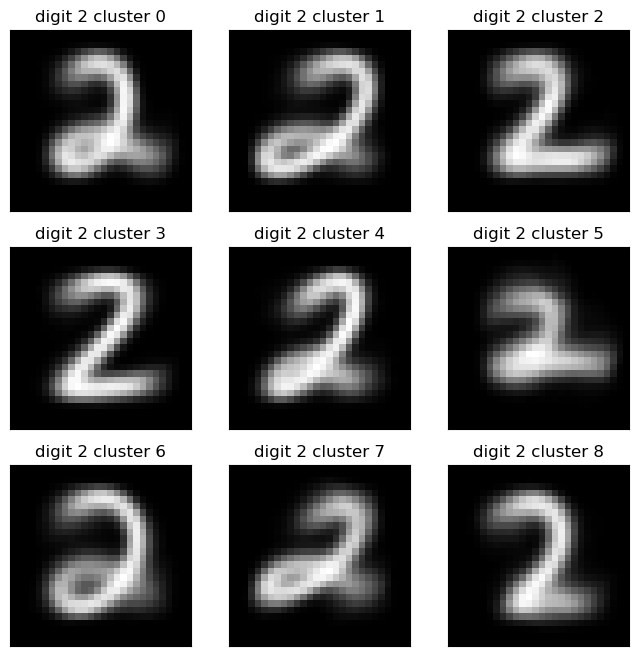

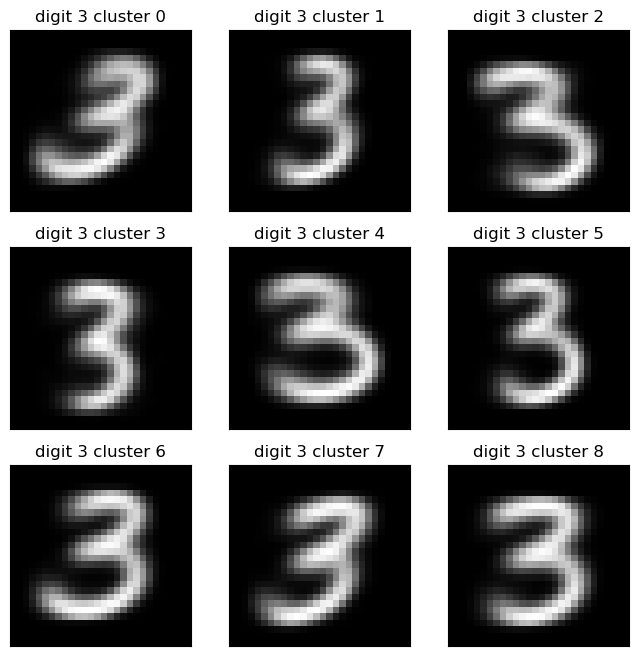

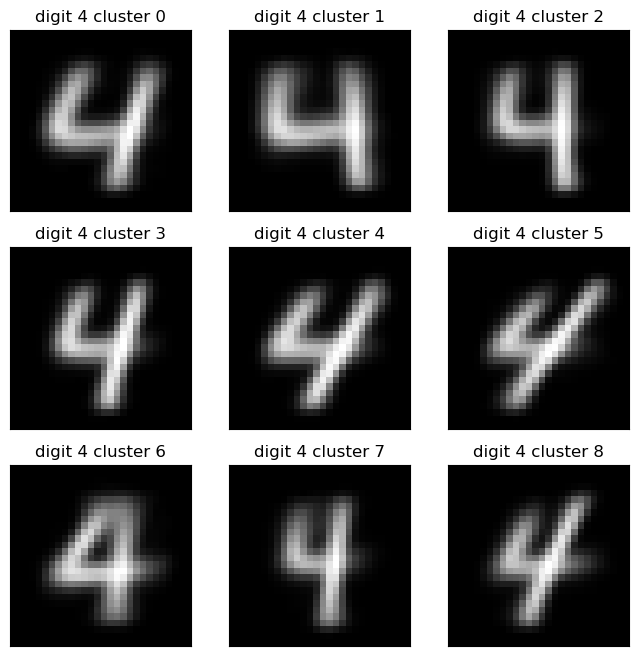

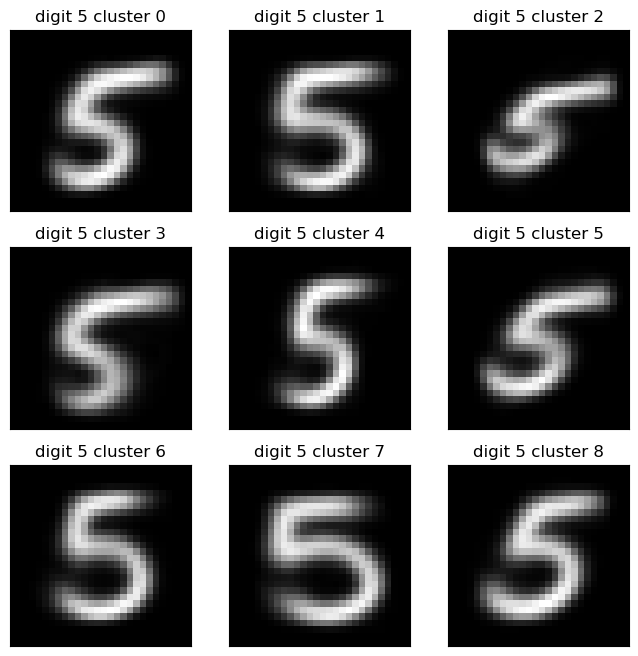

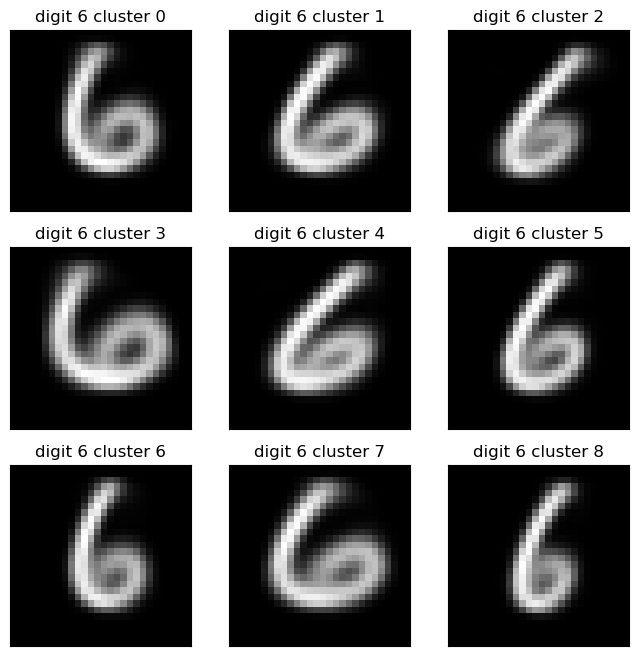

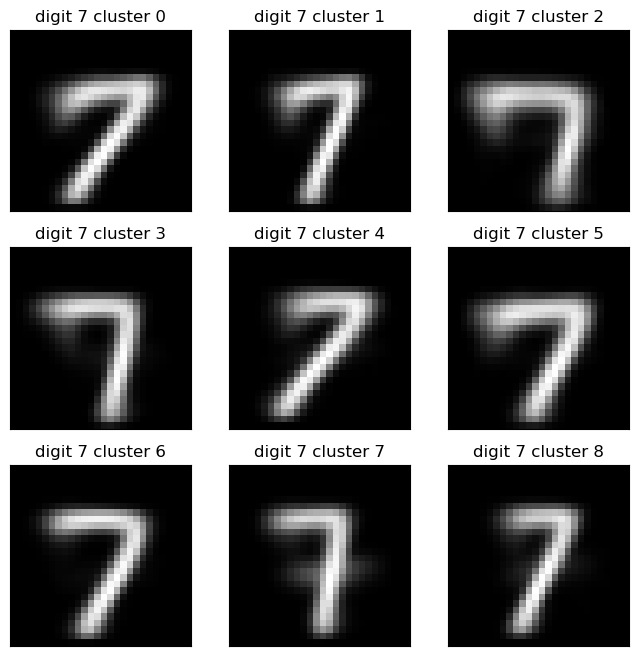

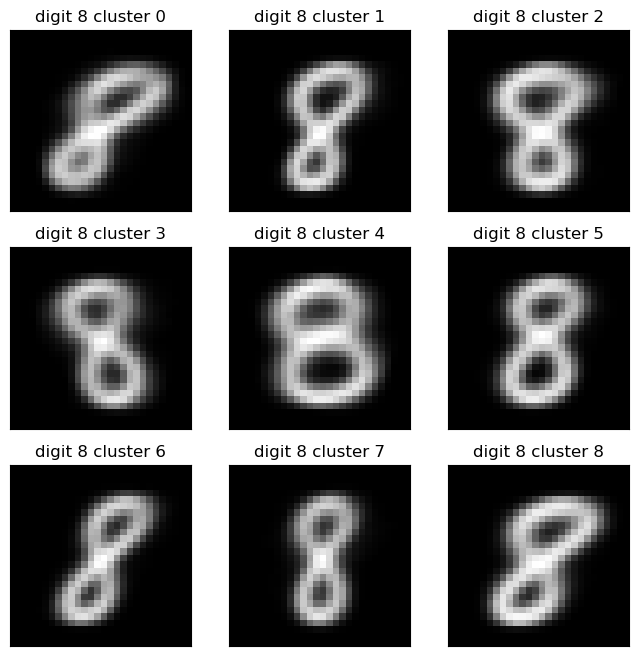

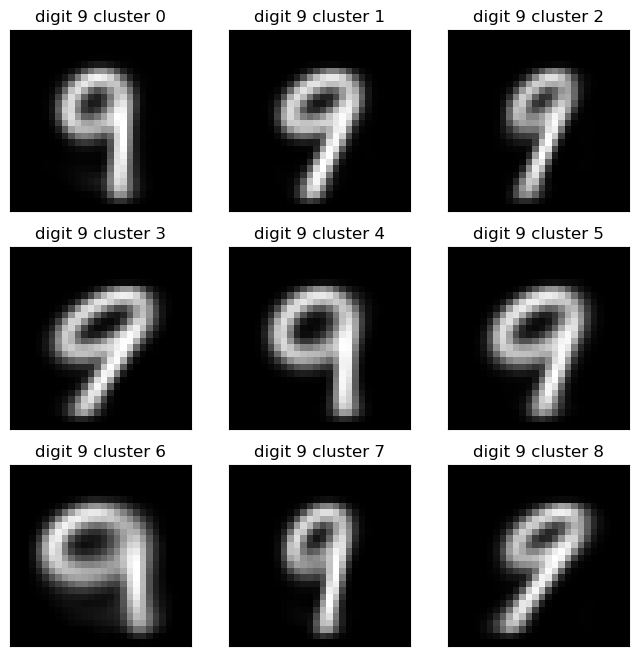

In [7]:
# Create a version of the data with a labeled clusters column for specific purposes
final_train_set_clusters = final_train_set.copy()
arr = np.arange(9)
rep_arr = np.tile(arr, 10)
final_train_set_clusters['clusters'] = rep_arr

# Create a 3x3 grid of images for each digit and cluster
groups = final_train_set_clusters.groupby('target')
for digit, data in groups:
    fig, ax = plt.subplots(3, 3, figsize=(8,8), )
    i = j = 0
    for row in data.iterrows():
        row_features = row[1][:-2]  # Exclude the target and cluster columns
        row_identifiers = row[1][-2:]   # Include only the target and cluster columns
        img = pd.to_numeric(row_features).values.reshape(28, 28)
        ax[i,j].imshow(img, cmap='gray')
        ax[i,j].set_xticks([]) 
        ax[i,j].set_yticks([]) 
        ax[i,j].set_title('digit ' + str(row_identifiers[-2]) + ' cluster ' + str(row_identifiers[-1]))
        
        # Increment the row and column counters
        j+=1
        if j == 3:
            j = 0
            i += 1
    plt.show()

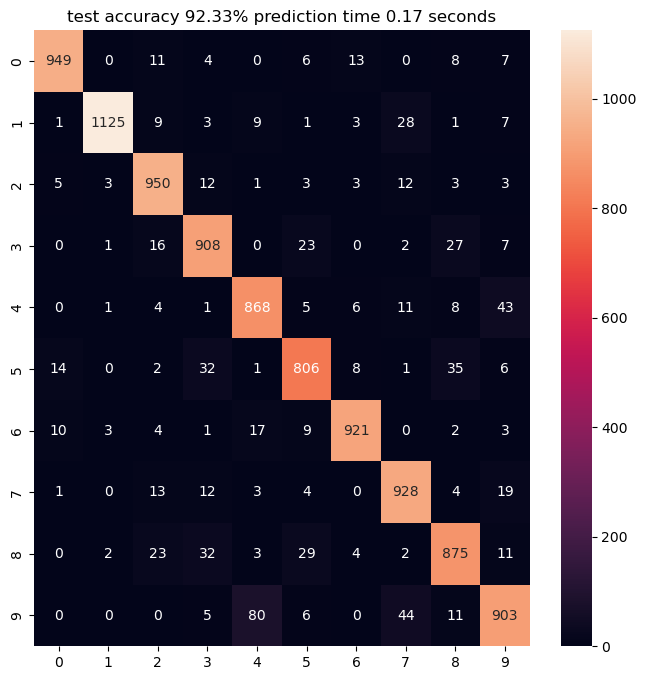

In [8]:
y_pred = y_pred.astype(int) # Convert the prediction column to integers to avoid errors

my_confusion_matrix = confusion_matrix(y_pred, y_test)
accuracy = my_confusion_matrix.diagonal().sum() / my_confusion_matrix.sum() * 100

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8,8))
plt.title('test accuracy ' + str(accuracy) + '% prediction time ' + str(prediction_time) + ' seconds')
plt.xlabel('true')
plt.ylabel('predicted')
sn.heatmap(my_confusion_matrix, annot=True, fmt='.4g')
plt.show()



/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


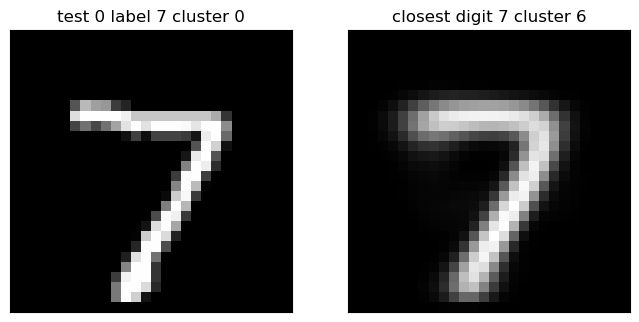

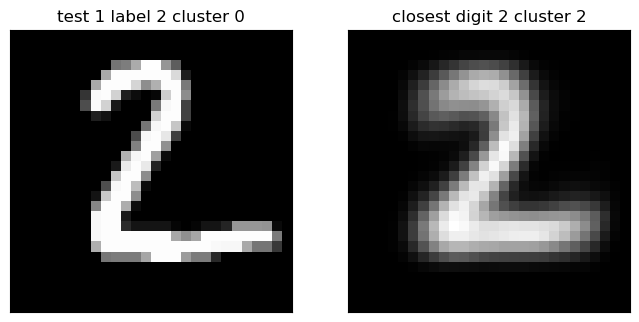

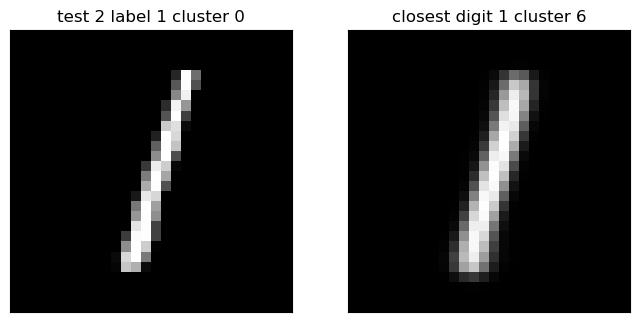

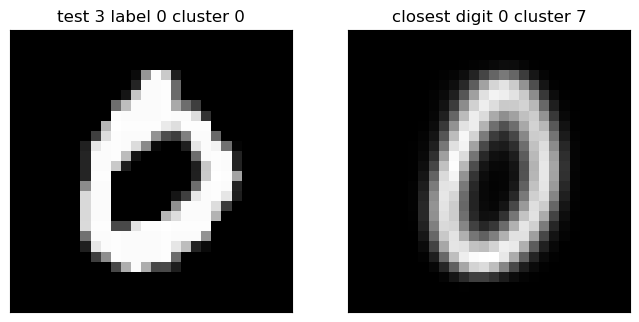

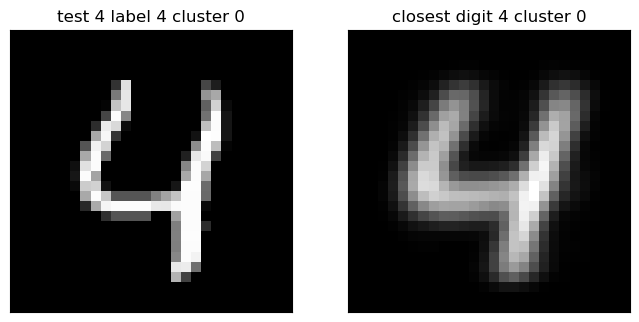

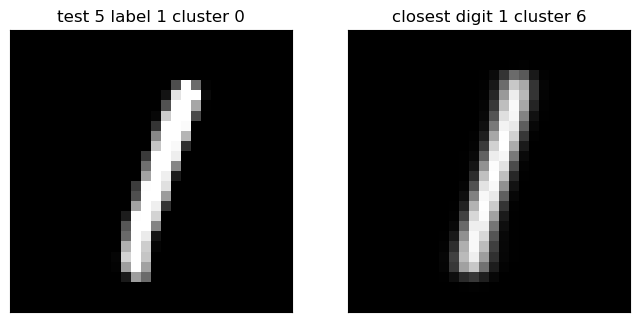

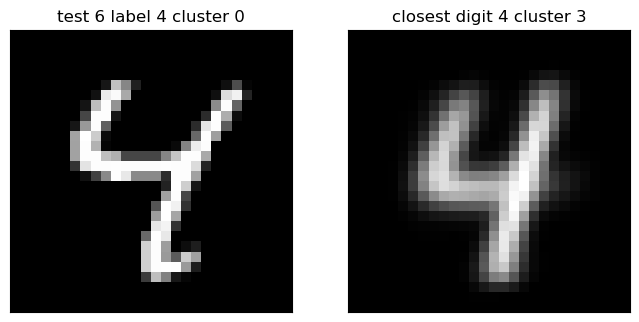

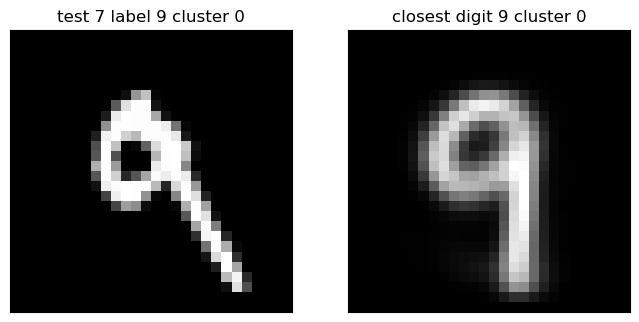

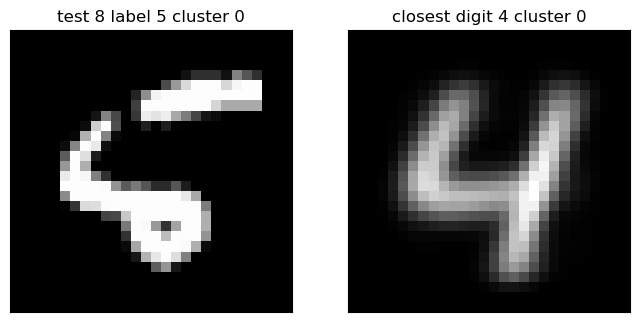

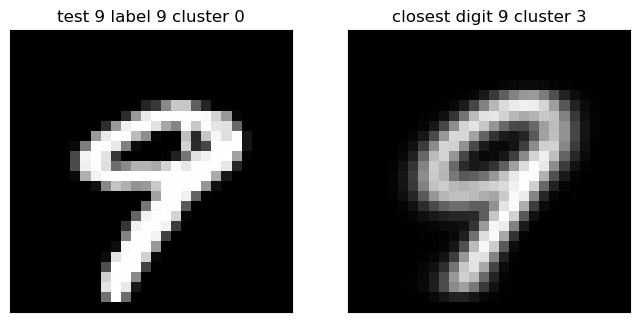

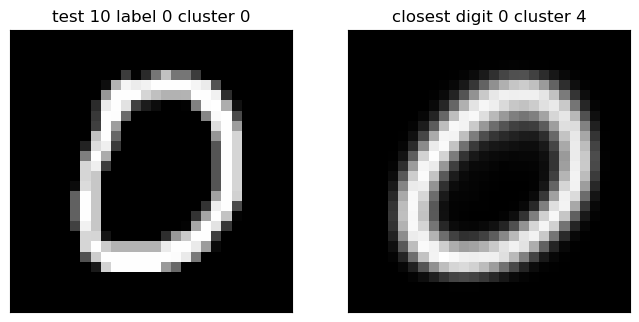

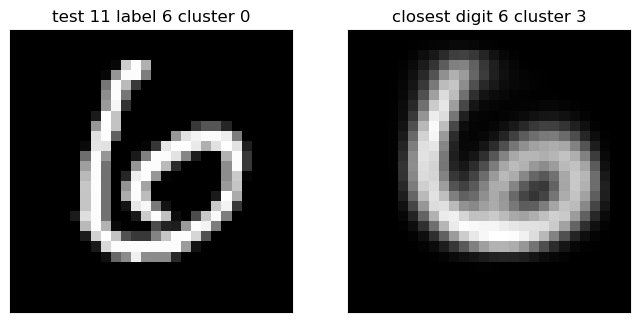

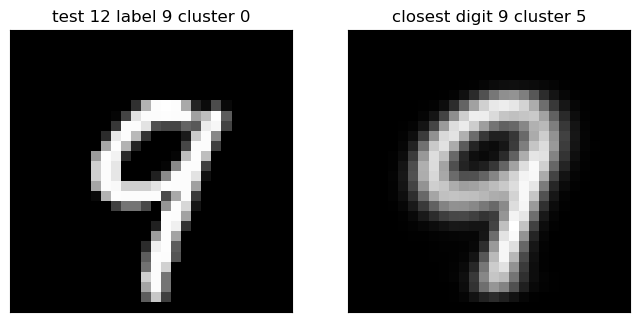

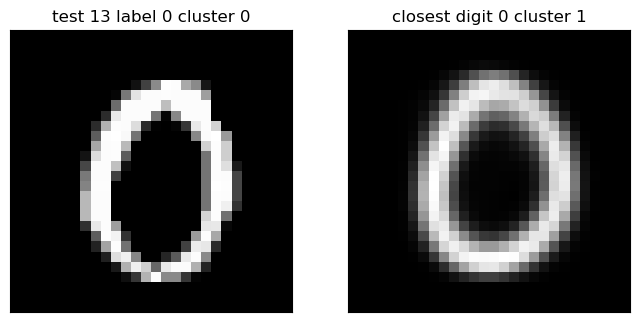

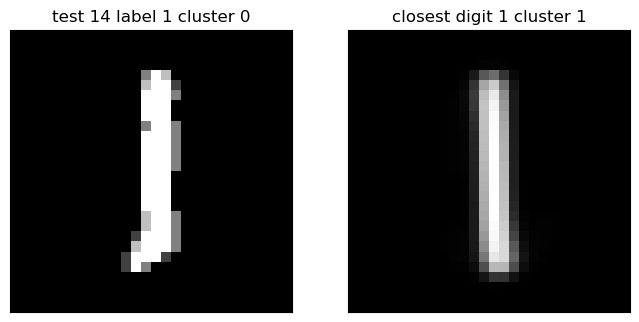

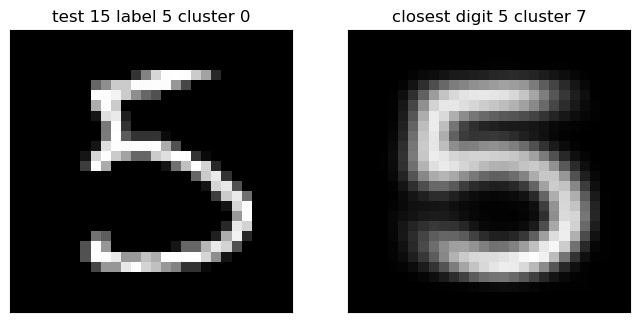

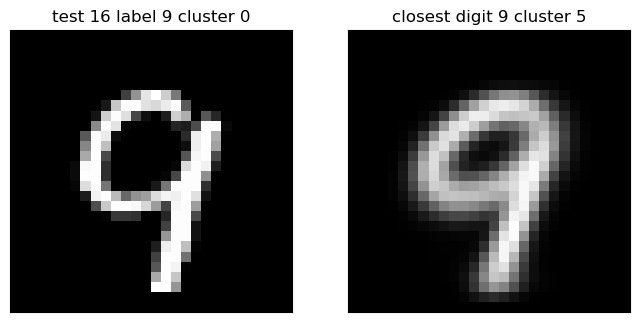

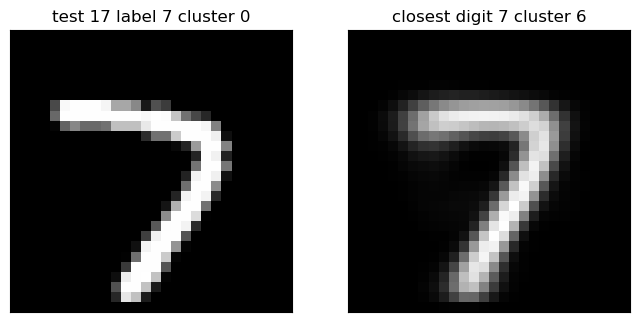

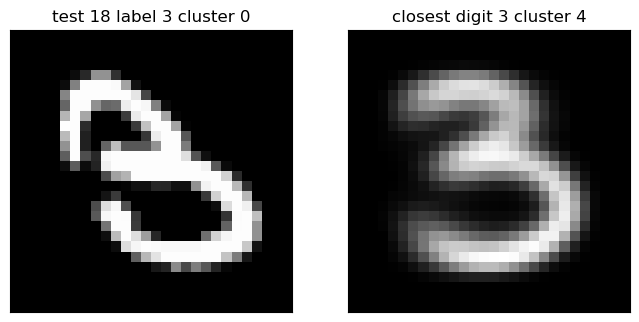

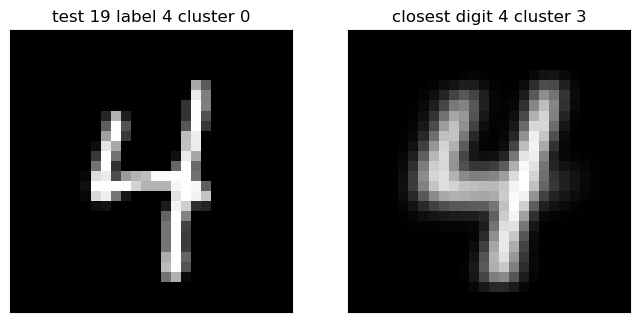

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Identify the nearest cluster to each test digit for the first 20 test digits
distances, indices = knn.kneighbors(X_test[:20])
nearest_clusters_indices = indices[:, 0]

# Create a DataFrame of the nearest clusters data according to the identified indices
nearest_clusters = final_train_set.iloc[nearest_clusters_indices].drop('target', axis=1)

rows = 20

# Create a 1x2 grid of images for each test digit and its nearest cluster
for i in range(rows):
    # Plot the test digit image
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    img = pd.to_numeric(X_test.iloc[i, :]).values.reshape(28, 28)
    ax[0].imshow(img, cmap='gray')
    ax[0].set_xticks([]) 
    ax[0].set_yticks([]) 
    ax[0].set_title('test ' + str(i) + ' label ' + str(y_test[i]) + ' cluster ' + str(X_test.iloc[nearest_clusters_indices[i], -1]))

    # Plot the nearest cluster image
    img = pd.to_numeric(nearest_clusters.iloc[i, :]).values.reshape(28, 28)
    ax[1].imshow(img, cmap='gray')
    ax[1].set_xticks([]) 
    ax[1].set_yticks([]) 
    ax[1].set_title('closest digit ' + str(y_pred[i]) + ' cluster ' + str(final_train_set_clusters.iloc[nearest_clusters_indices[i], -1]))
    plt.show()
    